In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
import pandas as pd
from sklearn.impute import SimpleImputer

In [2]:
train = pd.read_csv('/kaggle/input/documentos-do-titanic/train1.csv')
test = pd.read_csv('/kaggle/input/documentos-do-titanic/teste1.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


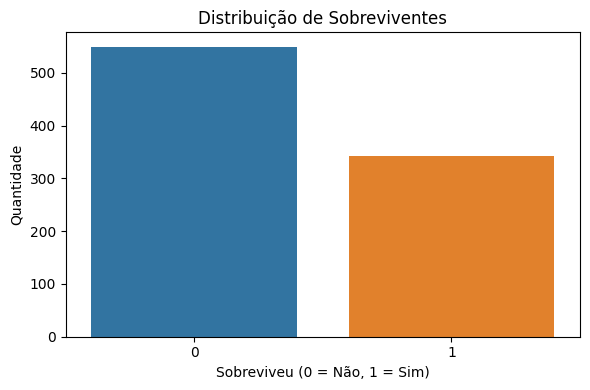

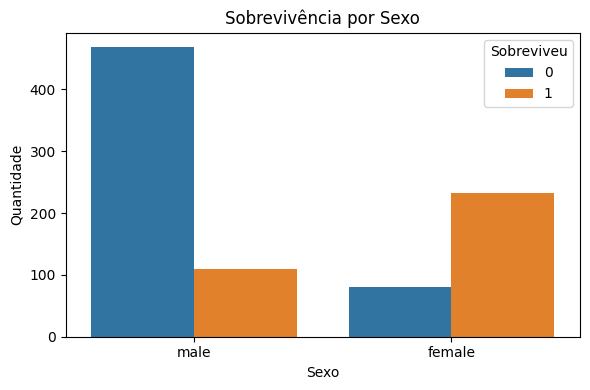

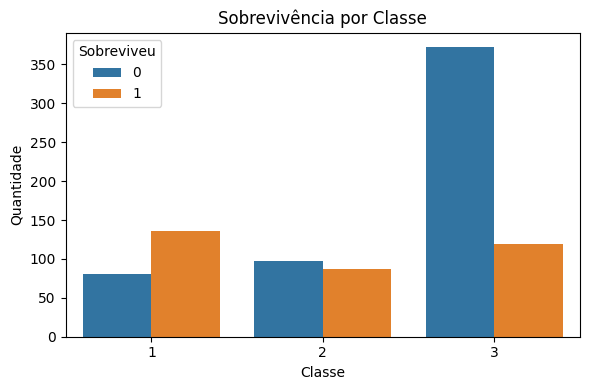

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


In [3]:
# Distribuição de sobreviventes
plt.figure(figsize=(6, 4))
sns.countplot(x='Survived', data=train)
plt.title('Distribuição de Sobreviventes')
plt.xlabel('Sobreviveu (0 = Não, 1 = Sim)')
plt.ylabel('Quantidade')
plt.tight_layout()
plt.show()

#Sobrevivência por sexo
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', data=train, hue='Survived')
plt.title('Sobrevivência por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Quantidade')
plt.legend(title='Sobreviveu')
plt.tight_layout()
plt.show()

#Sobrevivência por classe
plt.figure(figsize=(6, 4))
sns.countplot(x='Pclass', data=train, hue='Survived')
plt.title('Sobrevivência por Classe')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.legend(title='Sobreviveu')
plt.tight_layout()
plt.show()

# Estatísticas descritivas do dataset
summary_stats = train.describe()
print(summary_stats)


In [4]:
# Preencher valores ausentes
missing_fill = {
    'Age': lambda df: df['Age'].fillna(df['Age'].median()),
    'Embarked': lambda df: df['Embarked'].fillna('S'),
    'Fare': lambda df: df['Fare'].fillna(df['Fare'].median())
}

for col, func in missing_fill.items():
    if col in train.columns:
        train[col] = func(train)
    if col in test.columns:
        test[col] = func(test)

# Engenharia de atributos
def add_features(df):
    if {'SibSp', 'Parch'}.issubset(df.columns):
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    if 'Cabin' in df.columns:
        df['Has_Cabin'] = df['Cabin'].notnull().astype(int)
    if 'Sex' in df.columns:
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    return df

train = add_features(train)
test = add_features(test)
print("concluido")

concluido


In [5]:
# Seleção de features
selected_features = [
    'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
    'Fare', 'FamilySize', 'Has_Cabin', 'Embarked'
]

X = train[selected_features].copy()
y = train['Survived']

# Normalização das colunas numéricas
numeric_cols = ['Age', 'Fare']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
print("concluido")


concluido


In [6]:
# Preenchimento inicial 
X_filled = X.fillna({
    'Age': X['Age'].median() if 'Age' in X else 0,
    'Fare': X['Fare'].median() if 'Fare' in X else 0,
    'Embarked': 'S',
    'FamilySize': 1,
    'Has_Cabin': 0
})

# Preenche o restante com a moda das colunas
X_filled = X_filled.fillna(X_filled.mode().iloc[0])

# Codificação
X_encoded = pd.get_dummies(X_filled)

# Preenchimento final de segurança para eventuais NaNs restantes
X_encoded = X_encoded.fillna(0)

# Modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_encoded, y)

# Validação cruzada
scores = cross_val_score(model, X_encoded, y, cv=5)
print(f'Acurácia média: {scores.mean():.4f}')


Acurácia média: 0.8036


In [7]:
# Codificação one-hot
X_preprocessed = pd.get_dummies(X)

# Preenchimento final de NaNs
X_preprocessed = X_preprocessed.fillna(0)

# Modelo base
rf_classifier = RandomForestClassifier(random_state=42)

# Hiperparâmetros a serem testados
hyperparams = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Configuração do GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=hyperparams,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Treinamento com busca de hiperparâmetros
grid_search.fit(X_preprocessed, y)

# Resultados
print("Melhores parâmetros encontrados:", grid_search.best_params_)
print(f"Melhor acurácia média na validação cruzada: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Melhor acurácia média na validação cruzada: 0.8294


In [8]:
# Separar variáveis
X = train.drop(columns=['Survived', 'PassengerId'])
y = train['Survived']
X_test = test.drop(columns=['PassengerId'])

# One-hot encoding
X_train_encoded = pd.get_dummies(X)
X_test_encoded = pd.get_dummies(X_test)

# Alinhar colunas
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Converter para float
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# ❗ Remover colunas com todos os valores ausentes
X_train_encoded = X_train_encoded.dropna(axis=1, how='all')
X_test_encoded = X_test_encoded[X_train_encoded.columns]

# Imputar valores ausentes
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

# Criar DataFrames novamente
X_train_encoded = pd.DataFrame(X_train_imputed, columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(X_test_imputed, columns=X_train_encoded.columns)

# GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_encoded, y)

# Previsões
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_encoded)

# Submissão
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)

# Visualizar
submission.head()


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
